In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [2]:
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
use_gpu = torch.cuda.is_available()

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128
TRAIN_PATH = 'data/data-science-bowl-2018/train/'
TEST_PATH = 'data/data-science-bowl-2018/test/'

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# print(train_ids, test_ids)

In [6]:
# Get and resize train images and masks
x_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train[n] = img
    mask = np.zeros((height_out, width_out, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (height_out, width_out), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    y_train[n] = mask

# Get and resize test images
x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [02:18<00:00,  4.83it/s]

Getting and resizing test images ... 



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 90.69it/s]

Done!


In [7]:
x_train.shape, y_train.shape, x_test.shape

((670, 128, 128, 3), (670, 128, 128, 1), (65, 128, 128, 3))

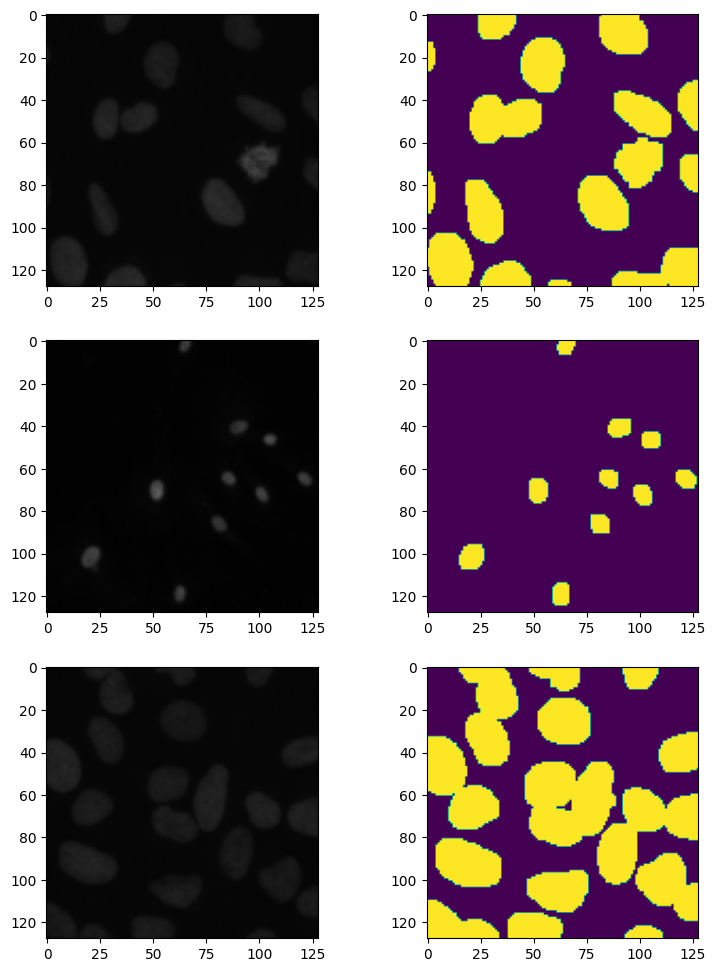

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
ax[0][0].imshow(x_train[0])
ax[0][1].imshow(np.squeeze(y_train[0]))
ax[1][0].imshow(x_train[1])
ax[1][1].imshow(np.squeeze(y_train[1]))
ax[2][0].imshow(x_train[2])
ax[2][1].imshow(np.squeeze(y_train[2]))

In [9]:
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.25)

In [10]:
x_train = x_train.transpose((0,3,1,2))
y_train = y_train.transpose((0,3,1,2))
x_val = x_val.transpose((0,3,1,2))
y_val = y_val.transpose((0,3,1,2))

In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((502, 3, 128, 128),
 (502, 1, 128, 128),
 (168, 3, 128, 128),
 (168, 1, 128, 128))

# U-Net Implementation

In [12]:
batch_size = 64
epochs = 10
epoch_lapse = 20
threshold = 0.33
sample_size = None

In [13]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.Sigmoid(),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode4 = self.contracting_block(256, 512)
        self.conv_maxpool4 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=1024, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(1024),
                            torch.nn.Conv2d(kernel_size=3, in_channels=1024, out_channels=1024, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(1024),
                            torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode4 = self.expansive_block(1024, 512, 256)
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        # print(encode_block1.shape)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        encode_block4 = self.conv_encode4(encode_pool3)
        encode_pool4  = self.conv_maxpool4(encode_block4)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool4)
        # Decode
        # print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, encode_pool3.shape, bottleneck1.shape)
        # print('Decode Block 3')
        # print(bottleneck1.shape, encode_block3.shape)
        decode_block4 = self.crop_and_concat(bottleneck1, encode_block4, crop=True)
        cat_layer3 = self.conv_decode4(decode_block4)
        decode_block3 = self.crop_and_concat(cat_layer3, encode_block3, crop=True)
        # print(decode_block3.shape)
        #print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        # print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        #print(cat_layer1.shape, encode_block1.shape)
        #print('Final Layer')
        #print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        #print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        #print(final_layer.shape)
        return  final_layer

In [14]:
def train_step(inputs, labels, optimizer, criterion, batch_size):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows)
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    #print(outputs.shape)
    outputs = outputs.reshape(batch_size*width_out*height_out, 2)
    labels = labels.reshape(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [15]:
print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Version: ", torch.version.cuda)
print("Number of CUDA Devices: ", torch.cuda.device_count())
print("CUDA Device Name: ", torch.cuda.get_device_name(0))  # Name of first CUDA device
learning_rate = 0.01
unet = UNet(in_channel=3,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

CUDA Available:  True
CUDA Version:  12.1
Number of CUDA Devices:  1
CUDA Device Name:  NVIDIA GeForce RTX 4070 Laptop GPU


In [16]:
def get_val_loss(x_val, y_val, batch_size=batch_size):
    epoch_iter = np.ceil(x_val.shape[0] / batch_size).astype(int)
    for _ in range(epoch_iter):
        total_loss = 0
        for i in range(epoch_iter):
            batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size]).float()
            batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size].astype(int)).long()
            if use_gpu:
                batch_val_x = batch_train_x.cuda()
                batch_val_y = batch_train_y.cuda()
            m = batch_val_x.shape[0]
            outputs = unet(batch_val_x)
            outputs = outputs.permute(0, 2, 3, 1)
            # outputs.shape =(batch_size, img_cols, img_rows, n_classes)
            #print(outputs.shape)
            outputs = outputs.reshape(m*width_out*height_out, 2)
            labels = batch_val_y.reshape(m*width_out*height_out)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.data
            gc.collect()
    return total_loss / epoch_iter

In [17]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size].astype(int)).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion, batch_train_x.shape[0])
        total_loss += batch_loss
        gc.collect()
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


In [18]:
gc.collect()

0

In [19]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.squeeze((image_arr > 0.40)[1,:,:].astype(int)))
        ax[row_num][1].set_title("Segmented Image localization")
        ax[row_num][2].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][2].set_title("Target image")
    plt.show()

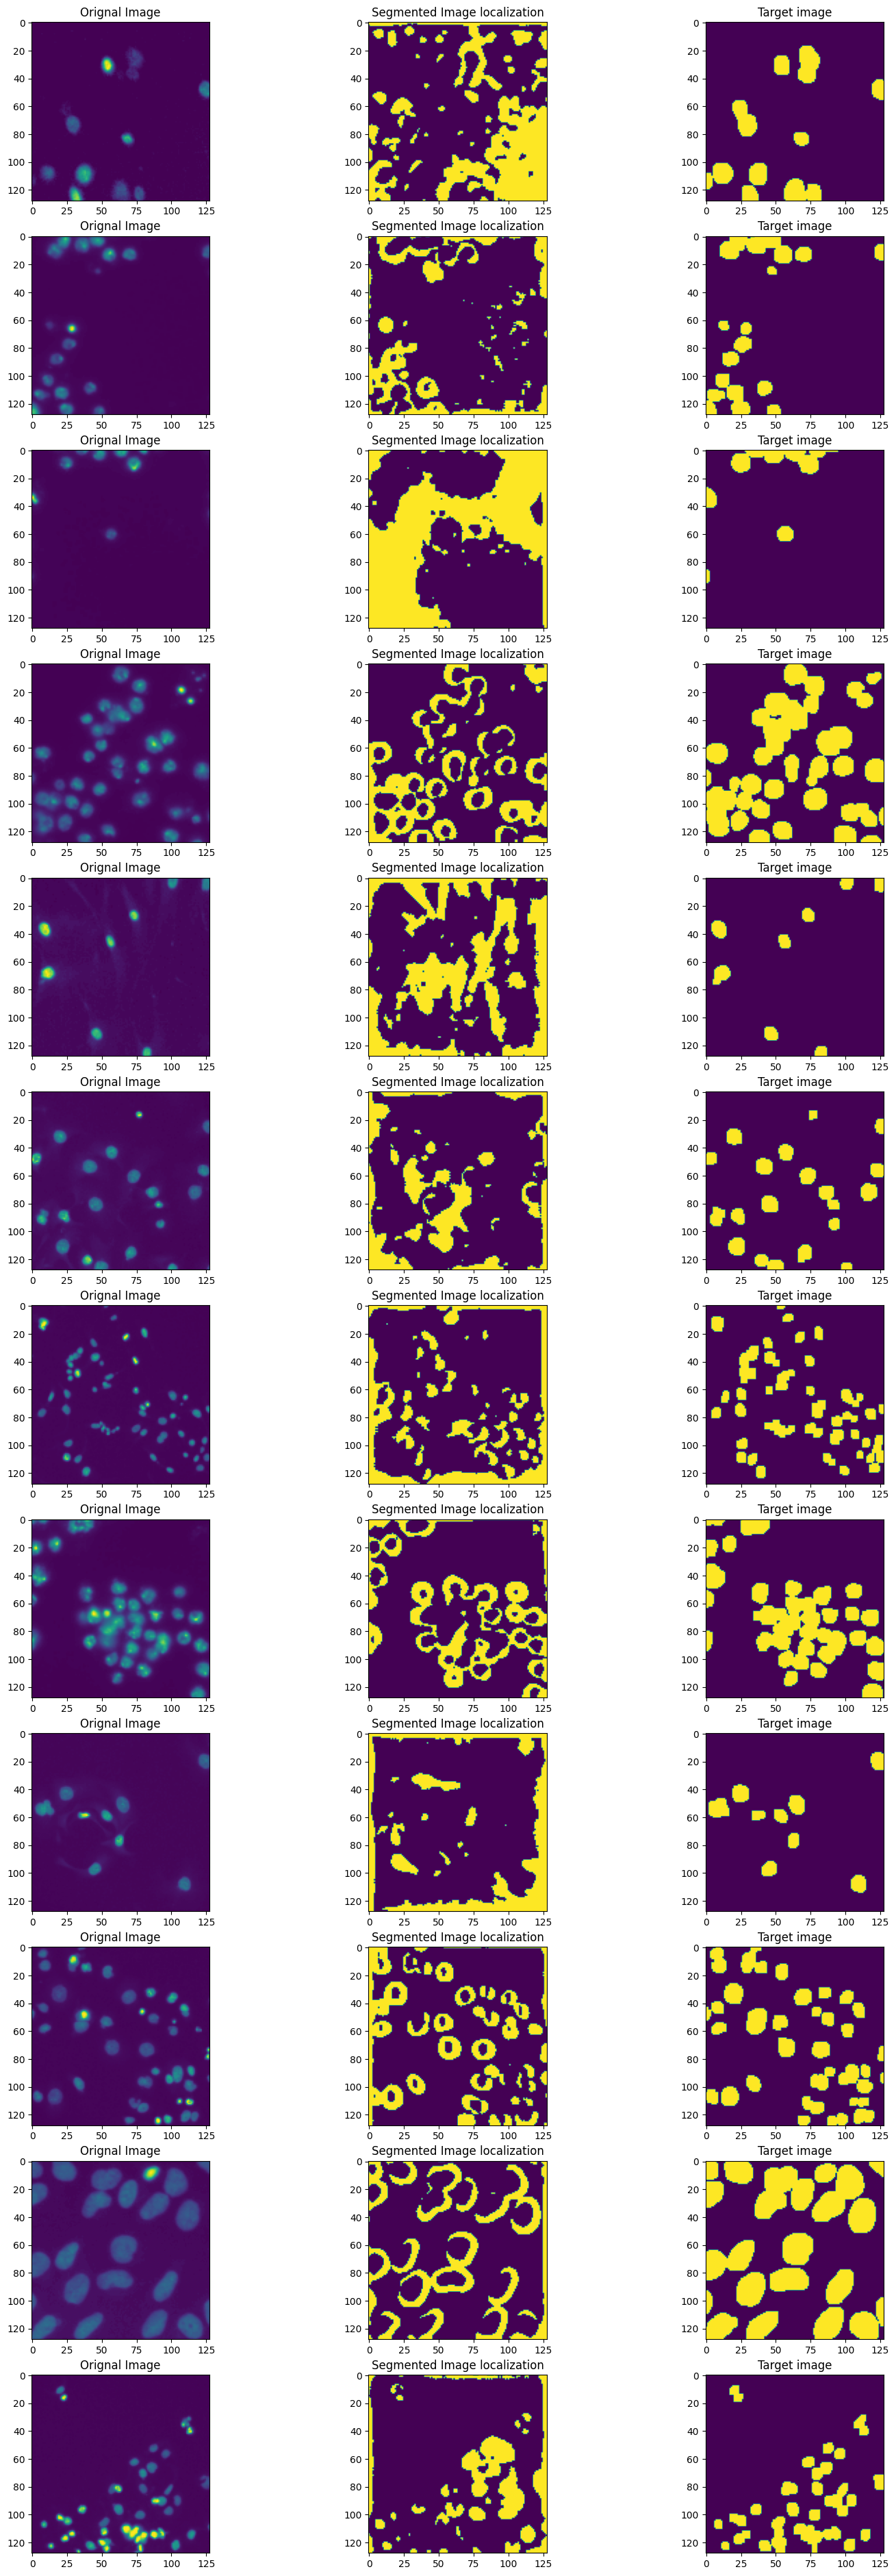

In [20]:
plot_examples(x_train, y_train, 12)

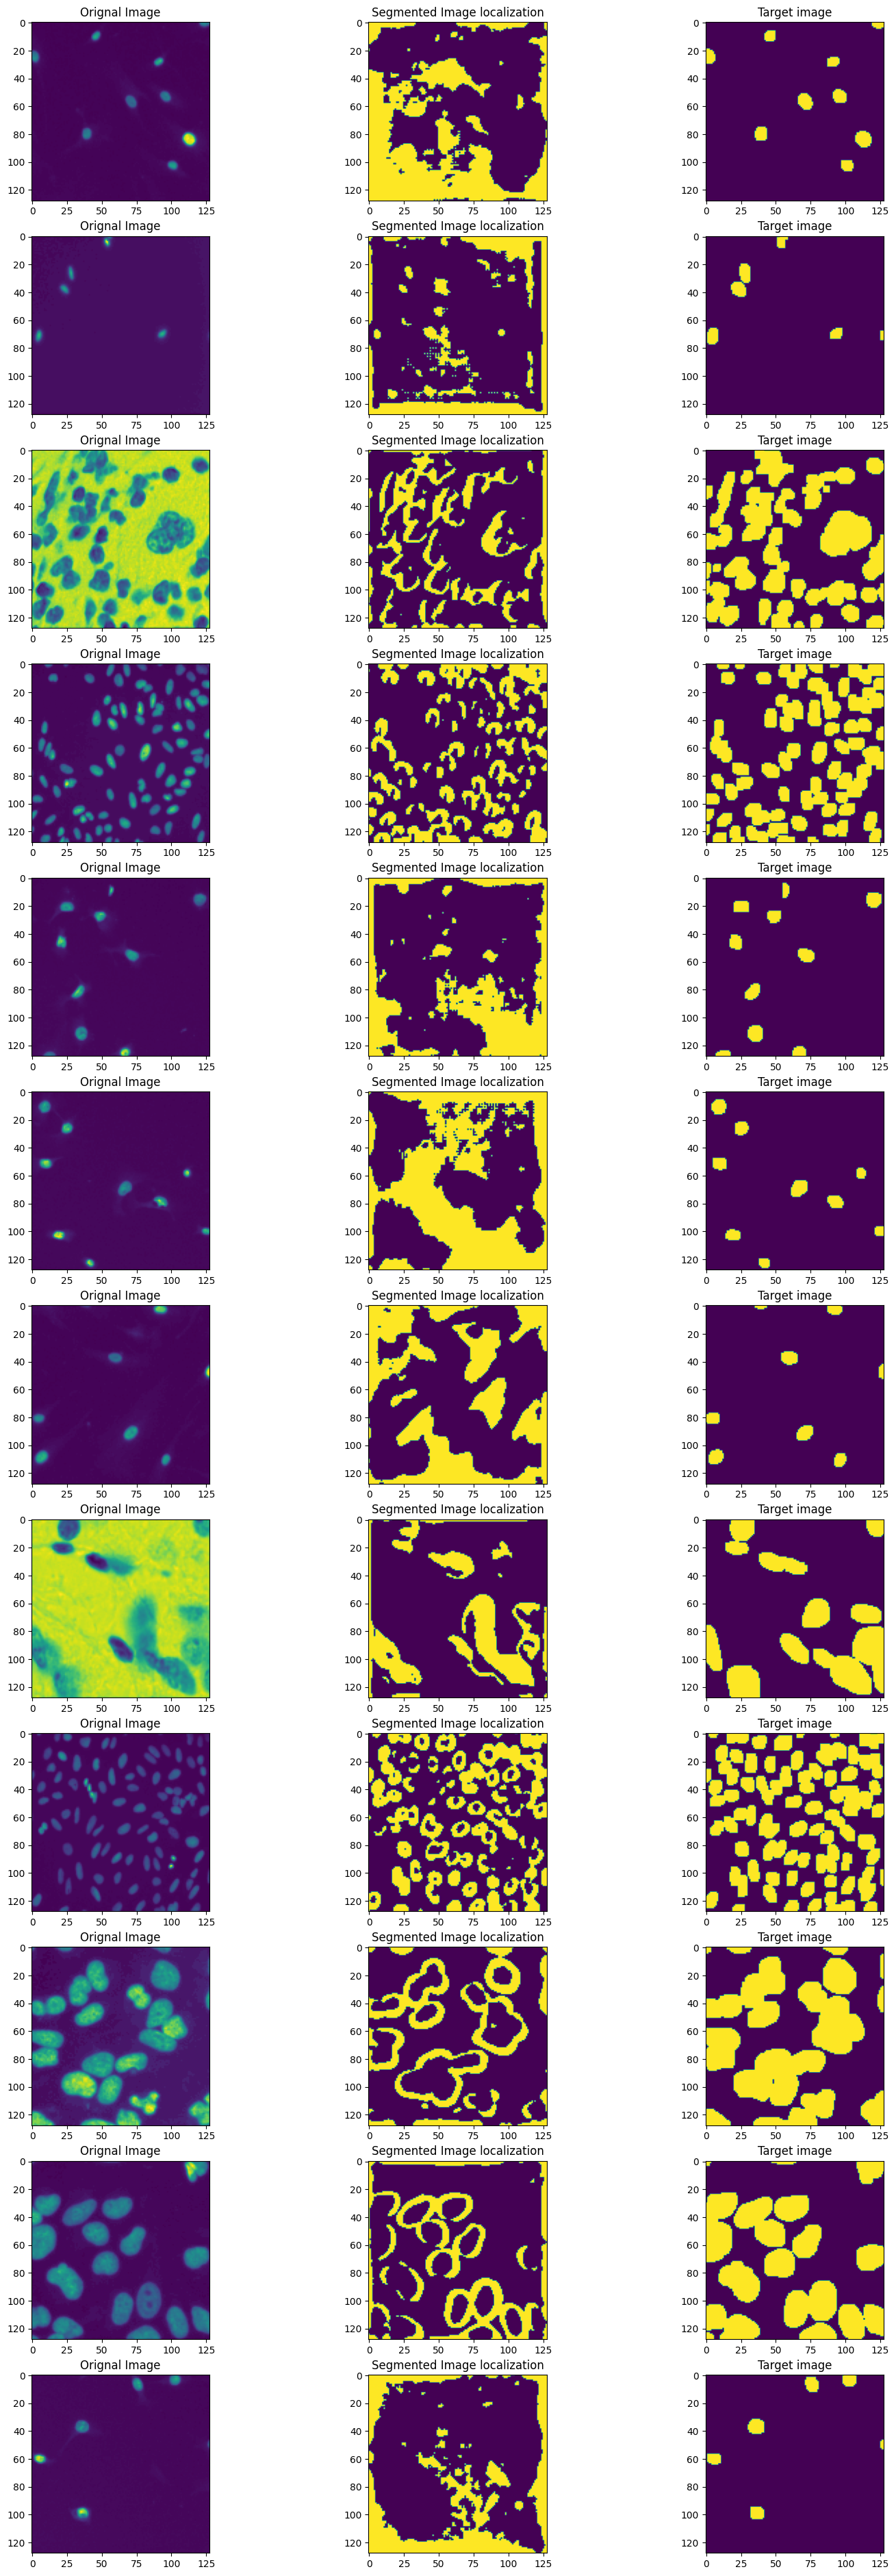

In [21]:
plot_examples(x_val, y_val, 12)

In [23]:
torch.save(unet.state_dict(), 'unet.pt')